In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

# 한글
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

### 전처리
final.csv를 받아서<br>
모델에 넣기 위해서 쓸모없는 column drop 및 integer encoding(label encoding)

In [2]:
df = pd.read_csv("final.csv", index_col = 0, encoding = "utf-8")


In [3]:
# pd.set_option('display.max_row',100)
# pd.set_option('display.max_column', 100)

In [4]:
df.drop(["시군구", "year_quarter", "addr_road", \
         "transaction_year_month", "transaction_date", \
         "서울_운영_영업_개월_평균", "서울_폐업_영업_개월_평균"], \
        axis = 1, inplace = True)
df["transaction_year"] = df["date"].str.split("-").str[0].astype(int)
df["transaction_month"] = df["date"].str.split("-").str[1].astype(int)
df["transaction_day"] = df["date"].str.split("-").str[2].astype(int)
df.drop("date", axis = 1, inplace = True)

encoder = LabelEncoder()
df["dong_encoded"] = encoder.fit_transform(df["dong"])
df["apt_encoded"] = encoder.fit_transform(df["apt"])
df.drop(["dong", "apt"], axis = 1, inplace = True)

df.rename(columns = {
    "exclusive_use_area": "전용면적",
    "year_of_completion": "건축년도",
    "floor": "층",
    "transaction_real_price": "실거래가",
    "transaction_year": "계약년도",
    "transaction_month": "계약월",
    "transaction_day": "계약일",
    "dong_encoded": "법정동",
    "apt_encoded": "아파트명"
}, inplace = True)
columns = ['소비자태도', '현재생활형편', '미래생활형편', '현재경기판단', '미래경기판단', '내구재구입태도', '주택구입태도', '현재소비지출', '미래소비지출', '순자산', '고용상황', '물가예상']
for column in columns:
    df.rename(columns = {
        column: column + "지수"
    }, inplace = True)
df.rename(columns = {
    "주택매매가격지수": "주택매매가격지수 전국"
}, inplace = True)
df.rename(columns = {
    "아파트실거래가격지수_서울": "아파트실거래가격지수",
    "아파트실거래가격지수_전국": "아파트실거래가격지수 전국",
    "주택매매가격지수_서울_아파트": "주택매매가격지수"
}, inplace = True)
df.rename(columns = {
    "시장금리(콜)": "시장금리"
}, inplace = True)
df.reset_index(inplace = True, drop = True)

In [5]:
df

,전용면적,건축년도,층,실거래가,소비자태도지수,현재생활형편지수,미래생활형편지수,현재경기판단지수,미래경기판단지수,내구재구입태도지수,...,한강 근접 여부,준공 이래 경과년수,초등학교 개수,중학교 개수,고등학교 개수,계약년도,계약월,계약일,법정동,아파트명
0,77.75,1988,5,60000,90.6,81.0,94.9,55.6,80.0,88.0,...,0,27,6,3,4,2015,1,11,8,604
1,77.75,1988,5,65000,90.6,81.0,94.9,55.6,80.0,88.0,...,0,27,6,3,4,2015,3,3,8,604
2,77.75,1988,2,62500,90.6,81.0,94.9,55.6,80.0,88.0,...,0,27,6,3,4,2015,3,7,8,604
3,77.75,1988,6,68000,95.7,86.2,100.4,65.2,83.1,89.3,...,0,27,6,3,4,2015,8,16,8,604
4,79.97,1987,5,73000,90.6,81.0,94.9,55.6,80.0,88.0,...,0,28,6,3,4,2015,1,29,8,605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608042,59.76,1998,13,68000,92.9,76.6,95.2,56.8,86.5,81.9,...,0,23,2,2,1,2021,4,16,273,6805
608043,59.76,1998,15,77000,93.2,79.2,97.1,55.0,81.6,81.6,...,0,23,2,2,1,2021,7,31,273,6805
608044,57.66,2003,5,30500,89.0,72.9,96.0,46.6,86.5,77.6,...,0,18,2,2,1,2021,2,27,273,6881
608045,72.22,2003,4,49500,92.9,76.6,95.2,56.8,86.5,81.9,...,0,18,2,2,1,2021,5,4,273,6882


In [6]:
df.columns

Index(['전용면적', '건축년도', '층', '실거래가', '소비자태도지수', '현재생활형편지수', '미래생활형편지수',
       '현재경기판단지수', '미래경기판단지수', '내구재구입태도지수', '주택구입태도지수', '현재소비지출지수', '미래소비지출지수',
       '순자산지수', '고용상황지수', '물가예상지수', '코스피지수', '코스닥지수', '코스피200', '코스피50',
       '시장금리', '주택매매가격지수 전국', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '생산자물가지수', '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX', '기준금리',
       '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수', '병원 개수', '보건소 개수', '보건지소 개수',
       '상급종합병원 개수', '요양병원 개수', '의원 개수', '정신병원 개수', '산부인과 개수', '종합병원 개수',
       '치과병원 개수', '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
       '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명'],
      dtype='object')

In [7]:
len(df.columns)

72

In [8]:
df.corr()

,전용면적,건축년도,층,실거래가,소비자태도지수,현재생활형편지수,미래생활형편지수,현재경기판단지수,미래경기판단지수,내구재구입태도지수,...,한강 근접 여부,준공 이래 경과년수,초등학교 개수,중학교 개수,고등학교 개수,계약년도,계약월,계약일,법정동,아파트명
전용면적,1.000000,0.058287,0.115754,0.578335,0.043387,0.044618,0.022754,0.047033,0.020898,0.044142,...,0.123076,-0.064032,-0.144582,-0.102752,-0.078329,-0.030034,0.022765,0.001179,0.039126,-0.007520
건축년도,0.058287,1.000000,0.191206,0.049989,-0.029208,-0.054422,-0.049934,-0.024700,-0.008847,-0.048029,...,-0.061125,-0.980960,-0.206465,-0.204209,-0.163350,0.087893,0.020926,0.001663,0.039363,-0.106974
층,0.115754,0.191206,1.000000,0.156303,0.004213,-0.002772,-0.012162,0.007511,0.004160,-0.000003,...,0.039309,-0.187466,-0.060843,-0.051613,-0.049731,0.017313,0.010352,0.001493,0.006690,-0.023840
실거래가,0.578335,0.049989,0.156303,1.000000,-0.094608,-0.182495,-0.152679,-0.085211,-0.009336,-0.196509,...,0.310278,0.010498,-0.196338,-0.124162,-0.103614,0.309760,0.073855,0.009365,0.014106,-0.014341
소비자태도지수,0.043387,-0.029208,0.004213,-0.094608,1.000000,0.731628,0.735413,0.845591,0.784615,0.845219,...,0.022882,-0.047678,-0.012203,-0.011491,-0.003455,-0.394072,0.283854,0.019926,-0.001991,-0.005743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
계약년도,-0.030034,0.087893,0.017313,0.309760,-0.394072,-0.638680,-0.569956,-0.358934,-0.072007,-0.665651,...,-0.024672,0.107238,0.000531,-0.001602,-0.005639,1.000000,-0.001726,0.007899,0.011515,-0.001157
계약월,0.022765,0.020926,0.010352,0.073855,0.283854,0.286673,0.029937,0.425591,0.034411,0.144527,...,0.005927,-0.021223,-0.006402,-0.006445,-0.004606,-0.001726,1.000000,-0.011357,0.005510,-0.003474
계약일,0.001179,0.001663,0.001493,0.009365,0.019926,0.009904,0.004470,0.025751,0.018434,0.003957,...,0.003692,-0.000120,0.001612,0.003773,0.002413,0.007899,-0.011357,1.000000,0.001492,0.002106
법정동,0.039126,0.039363,0.006690,0.014106,-0.001991,-0.002455,-0.010481,0.000860,-0.001371,-0.004610,...,0.091980,-0.037043,-0.019880,-0.045982,0.034279,0.011515,0.005510,0.001492,1.000000,0.229379


### Modeling

In [9]:
X = df[['전용면적', '건축년도', '층', '소비자태도지수', '현재생활형편지수', '미래생활형편지수',
       '현재경기판단지수', '미래경기판단지수', '내구재구입태도지수', '주택구입태도지수', '현재소비지출지수', '미래소비지출지수',
       '순자산지수', '고용상황지수', '물가예상지수', '코스피지수', '코스닥지수', '코스피200', '코스피50',
       '시장금리', '주택매매가격지수 전국', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '생산자물가지수', '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX', '기준금리',
       '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수', '병원 개수', '보건소 개수', '보건지소 개수',
       '상급종합병원 개수', '요양병원 개수', '의원 개수', '정신병원 개수', '산부인과 개수', '종합병원 개수',
       '치과병원 개수', '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
       '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (425632, 71) (425632,)
Test Data :  (182415, 71) (182415,)


In [10]:
%%time
Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

CPU times: user 15 s, sys: 119 ms, total: 15.1 s
Wall time: 15.1 s


In [11]:
y_hat = Model_dtr.predict(X_test)
y_hat

array([ 89900.,  45000., 154000., ...,  67000.,  96500.,  53500.])

### Validation

In [12]:
mse = mean_squared_error(y_test, y_hat)
np.sqrt(mse)

10717.07736737194

In [13]:
y.mean(), y.min(), y.max()

(65752.39449088639, 700, 1150000)

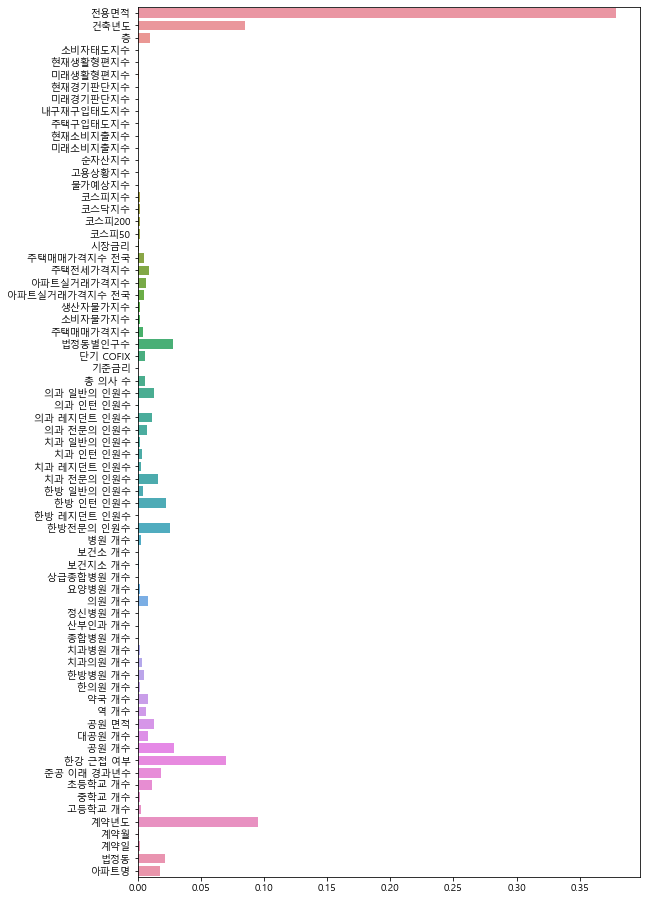

In [14]:
plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model2
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 49) (425632,)
Test Data :  (182415, 49) (182415,)
10709.711637890567


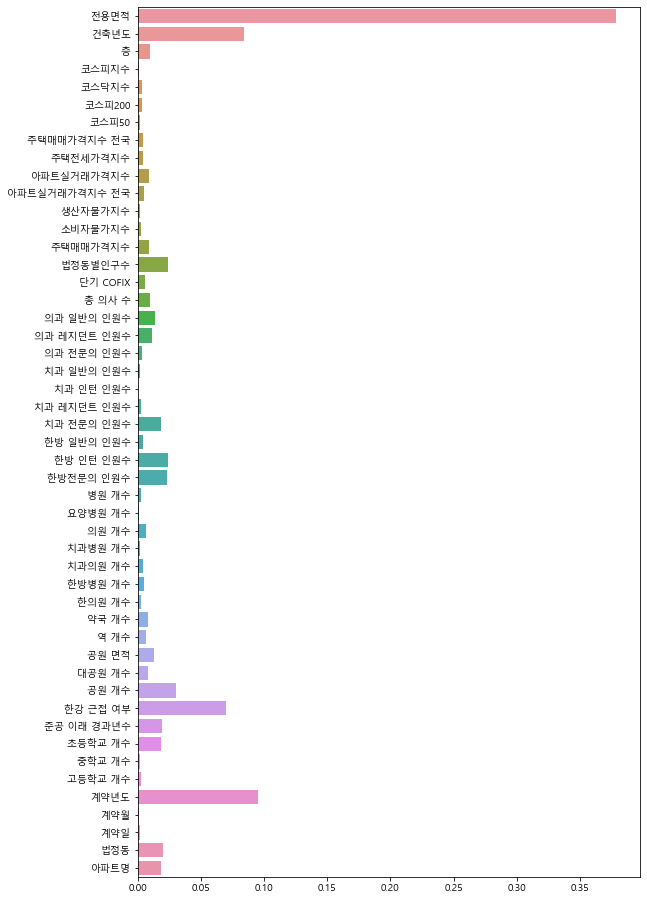

CPU times: user 11.8 s, sys: 320 ms, total: 12.1 s
Wall time: 12.1 s


In [15]:
%%time
X = df[['전용면적', '건축년도', '층', '코스피지수', '코스닥지수', '코스피200', '코스피50',
       '주택매매가격지수 전국', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '생산자물가지수', '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX',
       '총 의사 수', '의과 일반의 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방전문의 인원수', '병원 개수', '요양병원 개수', '의원 개수',
       '치과병원 개수', '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
       '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model3
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 36) (425632,)
Test Data :  (182415, 36) (182415,)
10429.708406478301


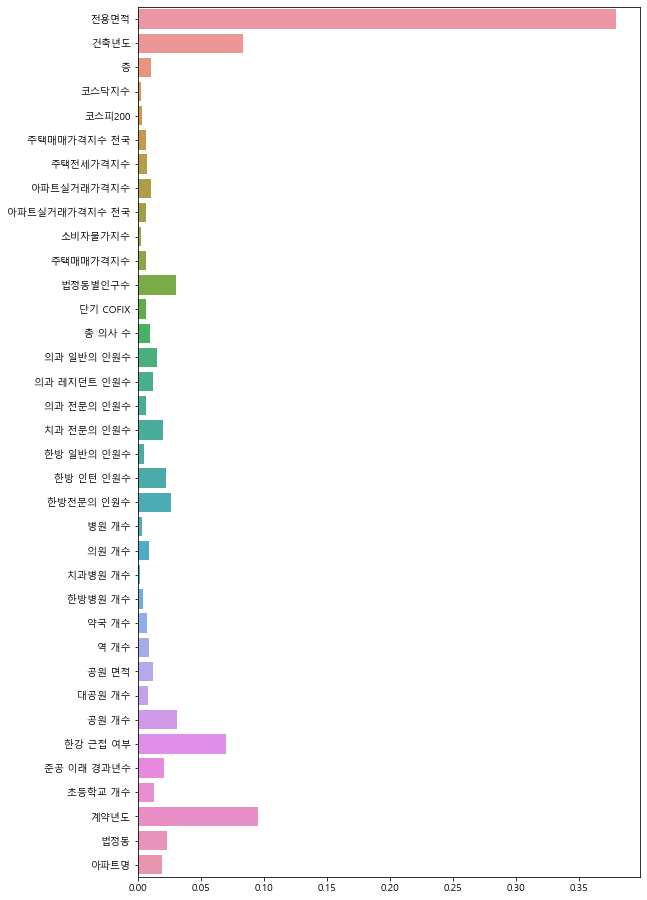

CPU times: user 8.81 s, sys: 124 ms, total: 8.94 s
Wall time: 8.94 s


In [16]:
%%time
X = df[['전용면적', '건축년도', '층', '코스닥지수', '코스피200',
       '주택매매가격지수 전국', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX',
       '총 의사 수', '의과 일반의 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방전문의 인원수', '병원 개수', '의원 개수',
       '치과병원 개수', '한방병원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수',
       '계약년도', '법정동', '아파트명']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model4
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 31) (425632,)
Test Data :  (182415, 31) (182415,)
10194.322821388814


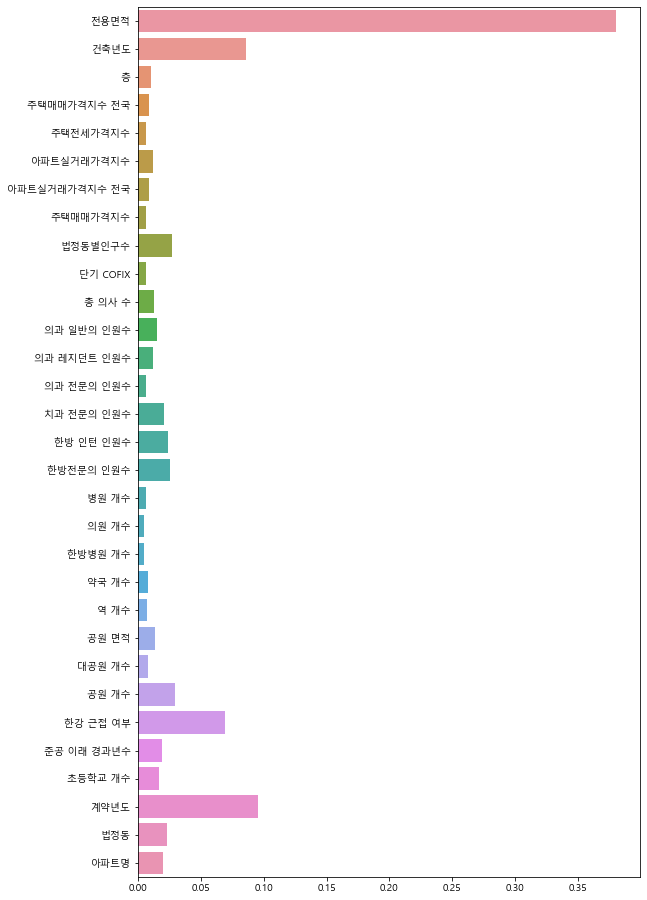

CPU times: user 7.97 s, sys: 80.1 ms, total: 8.05 s
Wall time: 8.04 s


In [17]:
%%time
X = df[['전용면적', '건축년도', '층',
       '주택매매가격지수 전국', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '주택매매가격지수', '법정동별인구수', '단기 COFIX',
       '총 의사 수', '의과 일반의 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 전문의 인원수',
       '한방 인턴 인원수', '한방전문의 인원수', '병원 개수', '의원 개수',
       '한방병원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수',
       '계약년도', '법정동', '아파트명']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model4-2
standardization

Train Data :  (425632, 31) (425632,)
Test Data :  (182415, 31) (182415,)
10188.129992218752


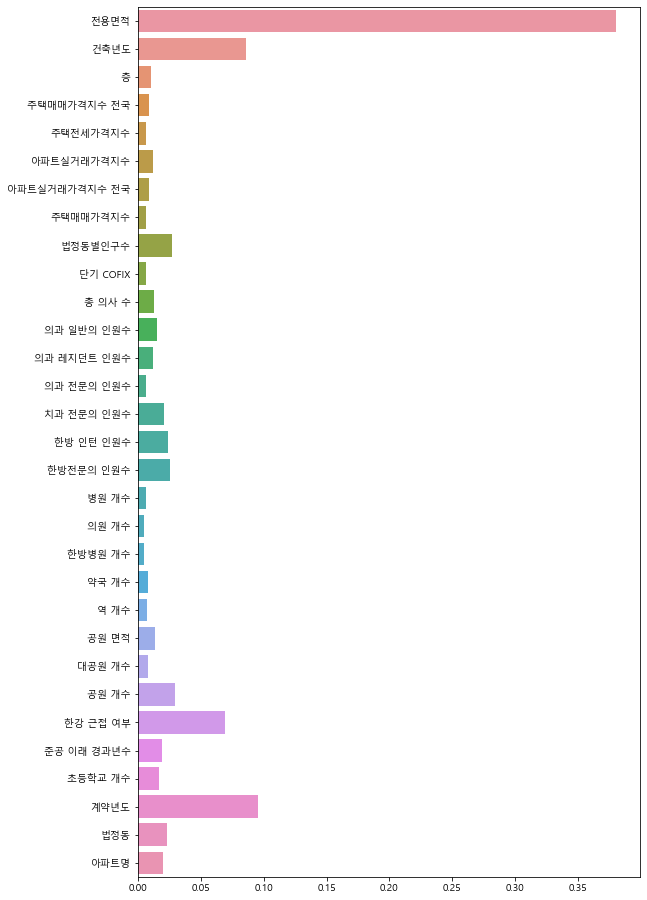

CPU times: user 7.81 s, sys: 276 ms, total: 8.09 s
Wall time: 8.09 s


In [18]:
%%time
X = df[['전용면적', '건축년도', '층',
       '주택매매가격지수 전국', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '주택매매가격지수', '법정동별인구수', '단기 COFIX',
       '총 의사 수', '의과 일반의 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 전문의 인원수',
       '한방 인턴 인원수', '한방전문의 인원수', '병원 개수', '의원 개수',
       '한방병원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수',
       '계약년도', '법정동', '아파트명']]

#######standardization#######
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#####################n#######

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X_std, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model5
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 20) (425632,)
Test Data :  (182415, 20) (182415,)
10003.33039662167


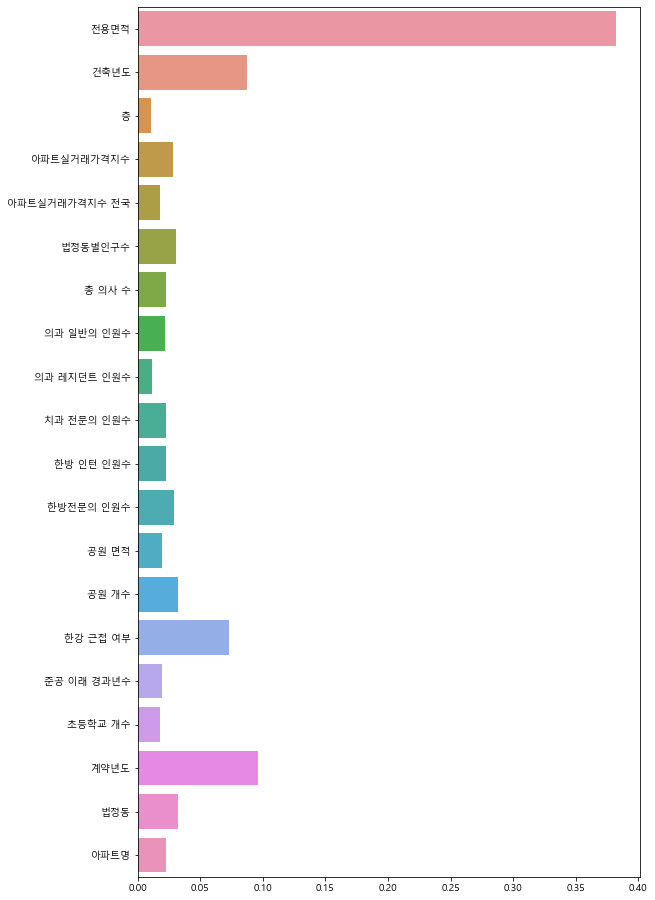

CPU times: user 5.22 s, sys: 67.9 ms, total: 5.29 s
Wall time: 5.29 s


In [19]:
%%time
X = df[['전용면적', '건축년도', '층',
       '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '법정동별인구수',
       '총 의사 수', '의과 일반의 인원수', '의과 레지던트 인원수',
       '치과 전문의 인원수',
       '한방 인턴 인원수', '한방전문의 인원수',
       '공원 면적',
       '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수',
       '계약년도', '법정동', '아파트명']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model6
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 18) (425632,)
Test Data :  (182415, 18) (182415,)
9923.43174446858


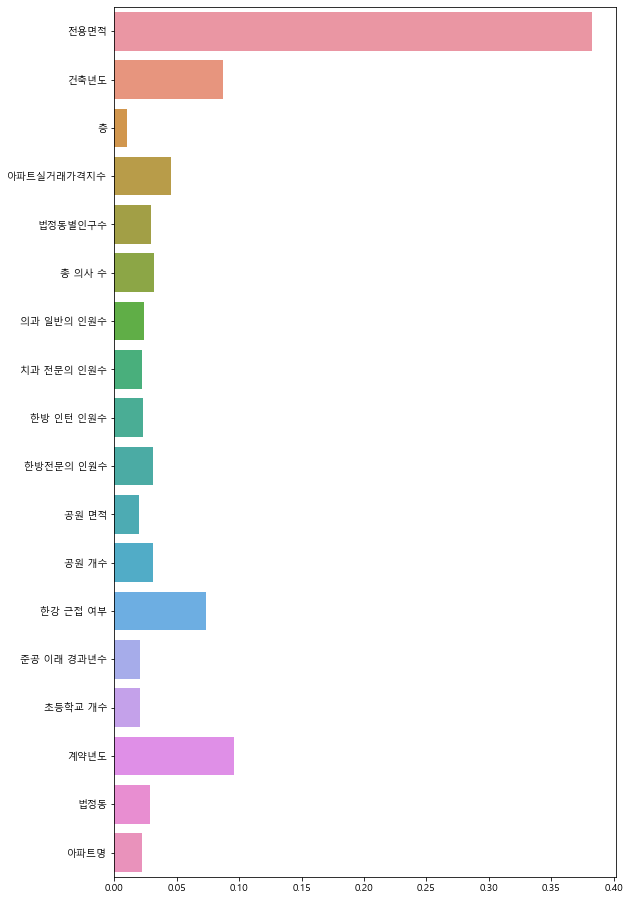

CPU times: user 4.67 s, sys: 71.9 ms, total: 4.74 s
Wall time: 4.74 s


In [20]:
%%time
X = df[['전용면적', '건축년도', '층',
       '아파트실거래가격지수',
       '법정동별인구수',
       '총 의사 수', '의과 일반의 인원수',
       '치과 전문의 인원수',
       '한방 인턴 인원수', '한방전문의 인원수',
       '공원 면적',
       '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수',
       '계약년도', '법정동', '아파트명']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model7
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 9) (425632,)
Test Data :  (182415, 9) (182415,)
10056.086754432501


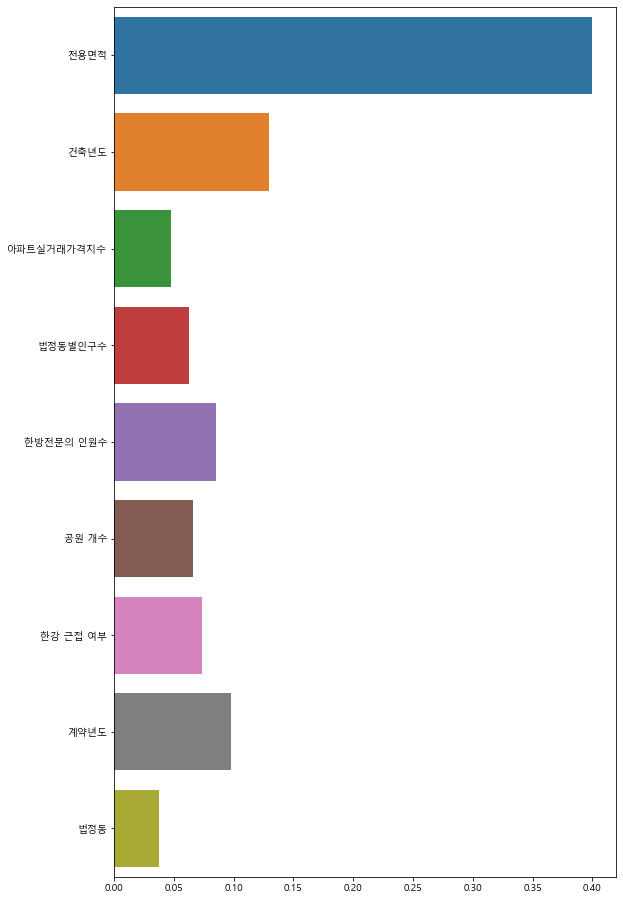

CPU times: user 2.37 s, sys: 7.83 ms, total: 2.38 s
Wall time: 2.37 s


In [21]:
%%time
X = df[['전용면적', '건축년도',
       '아파트실거래가격지수',
       '법정동별인구수',
       '한방전문의 인원수',
       '공원 개수', '한강 근접 여부',
       '계약년도', '법정동']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model8
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 7) (425632,)
Test Data :  (182415, 7) (182415,)
9577.257851234803


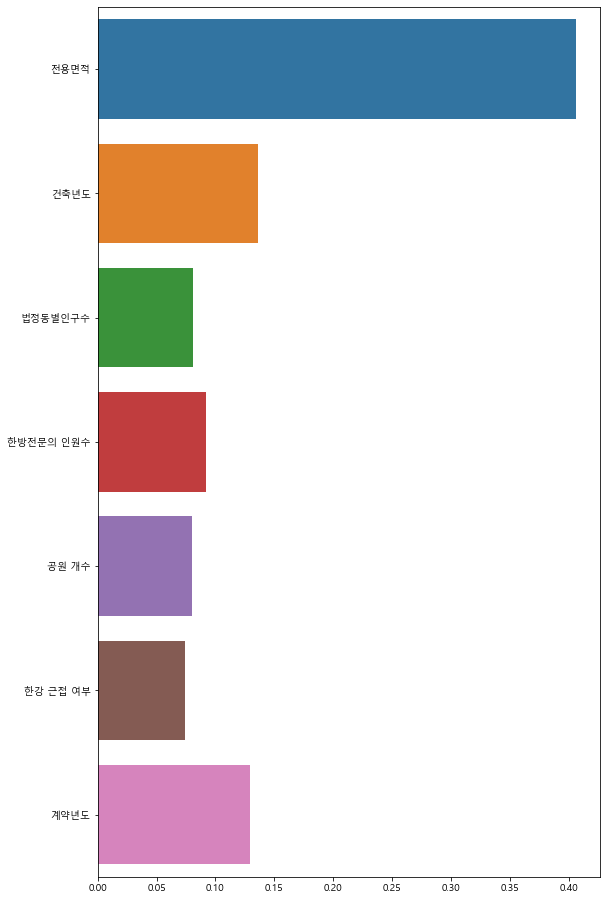

CPU times: user 1.65 s, sys: 113 µs, total: 1.65 s
Wall time: 1.65 s


In [22]:
%%time
X = df[['전용면적', '건축년도',
       '법정동별인구수',
       '한방전문의 인원수',
       '공원 개수', '한강 근접 여부',
       '계약년도']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model8-2
standardization

Train Data :  (425632, 7) (425632,)
Test Data :  (182415, 7) (182415,)
9568.72598334685


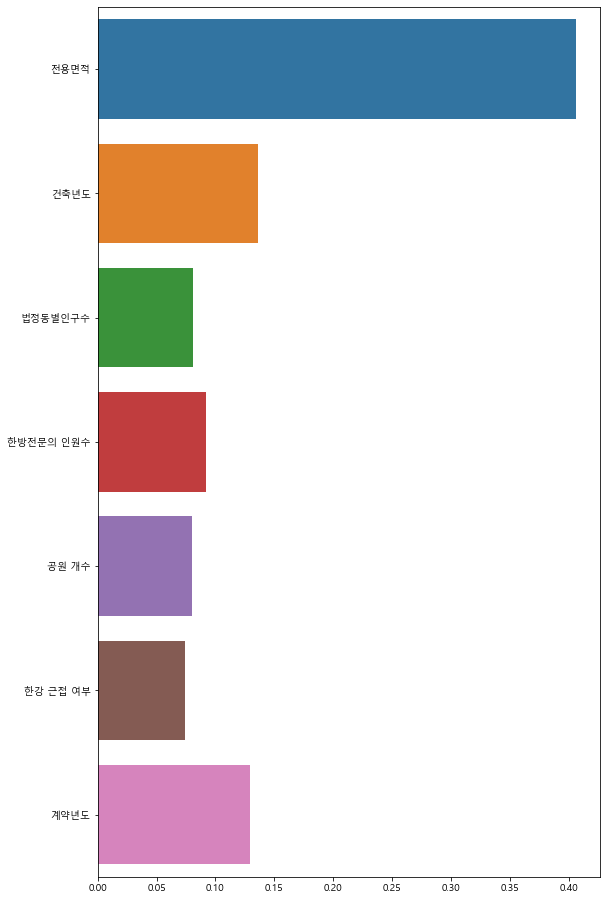

CPU times: user 1.81 s, sys: 0 ns, total: 1.81 s
Wall time: 1.81 s


In [23]:
%%time
X = df[['전용면적', '건축년도',
       '법정동별인구수',
       '한방전문의 인원수',
       '공원 개수', '한강 근접 여부',
       '계약년도']]

#######standardization#######
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#####################n#######

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X_std, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model8-3
standardization<br>
test_size = 0.1

Train Data :  (547242, 7) (547242,)
Test Data :  (60805, 7) (60805,)
8641.152714195343


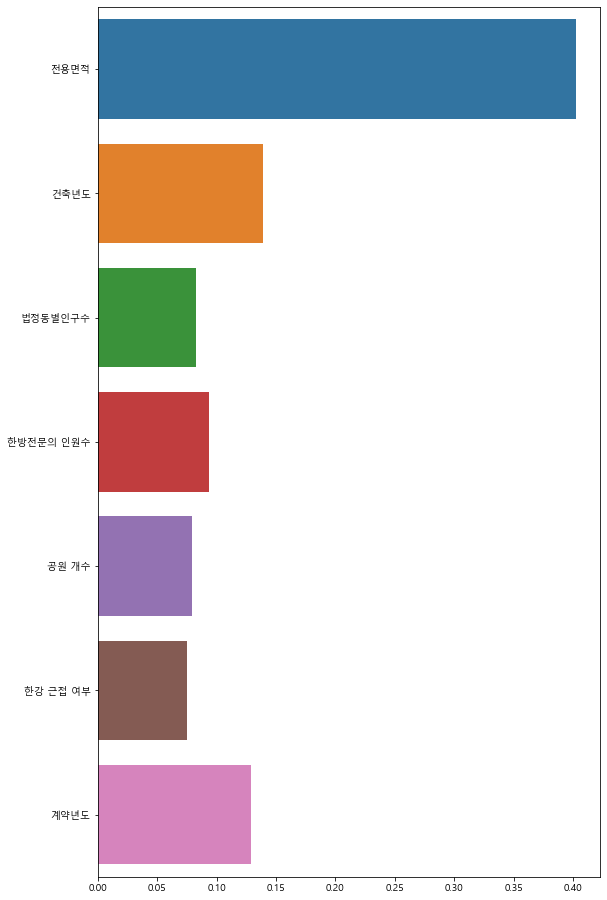

CPU times: user 2.21 s, sys: 28 ms, total: 2.24 s
Wall time: 2.24 s


In [24]:
%%time
X = df[['전용면적', '건축년도',
       '법정동별인구수',
       '한방전문의 인원수',
       '공원 개수', '한강 근접 여부',
       '계약년도']]

#######standardization#######
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#####################n#######

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X_std, y,
                                                    test_size = 0.1,
                                                    random_state = 0)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model8-4
standardization<br>
test_size = 0.1
random_state = 1~10

In [26]:
# list_temp = [1, 2, 3]
# sum(list_temp)/len(list_temp)

Train Data :  (547242, 7) (547242,)
Test Data :  (60805, 7) (60805,)
8641.152714195343
8605.81512852011
9043.044420693608
8698.960595016193
9215.650323976452
8809.728892106546
9423.405582350117
9029.345162215477
9305.590859552844
8704.064569618558
mean of mse (random_state == 0 ~ 9) : 8947.675824824524


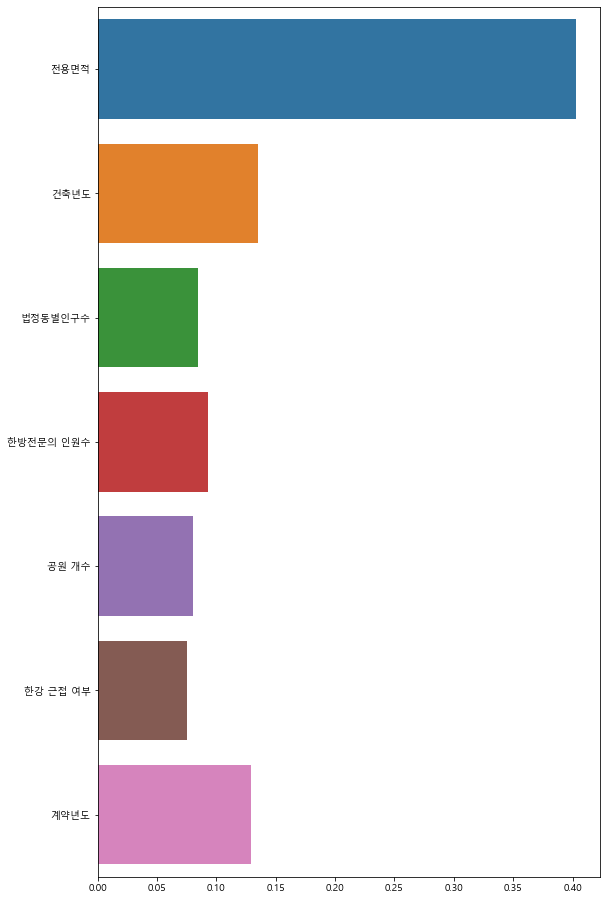

CPU times: user 19.9 s, sys: 51.3 ms, total: 20 s
Wall time: 20 s


In [27]:
%%time
X = df[['전용면적', '건축년도',
       '법정동별인구수',
       '한방전문의 인원수',
       '공원 개수', '한강 근접 여부',
       '계약년도']]

#######standardization#######
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#####################n#######

y = df['실거래가']

history_mse = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_std, y,
                                                        test_size = 0.1,
                                                        random_state = i)

    if i == 0:
        print('Train Data : ', X_train.shape, y_train.shape)
        print('Test Data : ', X_test.shape, y_test.shape)

    Model_dtr = DecisionTreeRegressor(random_state = 0)
    Model_dtr.fit(X_train, y_train)

    y_hat = Model_dtr.predict(X_test)

    mse = mean_squared_error(y_test, y_hat)
    print(np.sqrt(mse))
    history_mse.append(np.sqrt(mse))
print('mean of mse (random_state == 0 ~ 9) :', sum(history_mse)/len(history_mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model9
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 6) (425632,)
Test Data :  (182415, 6) (182415,)
10038.562418497477


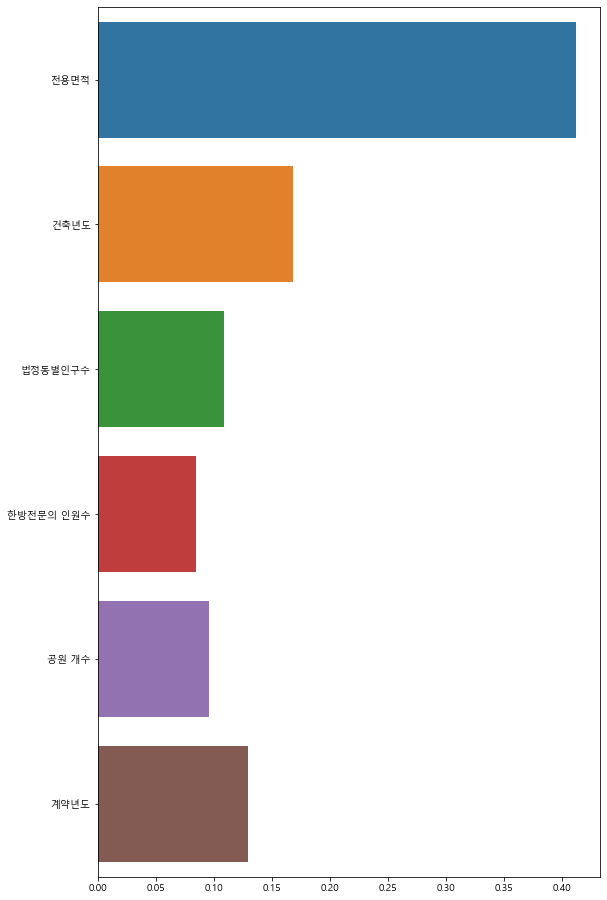

CPU times: user 1.62 s, sys: 3.91 ms, total: 1.62 s
Wall time: 1.62 s


In [28]:
%%time
X = df[['전용면적', '건축년도',
       '법정동별인구수',
       '한방전문의 인원수',
       '공원 개수',
       '계약년도']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

### Model10
feature importance를 참고하여 관련이 적어보이는 변수들은 제거

Train Data :  (425632, 5) (425632,)
Test Data :  (182415, 5) (182415,)
10798.514912176233


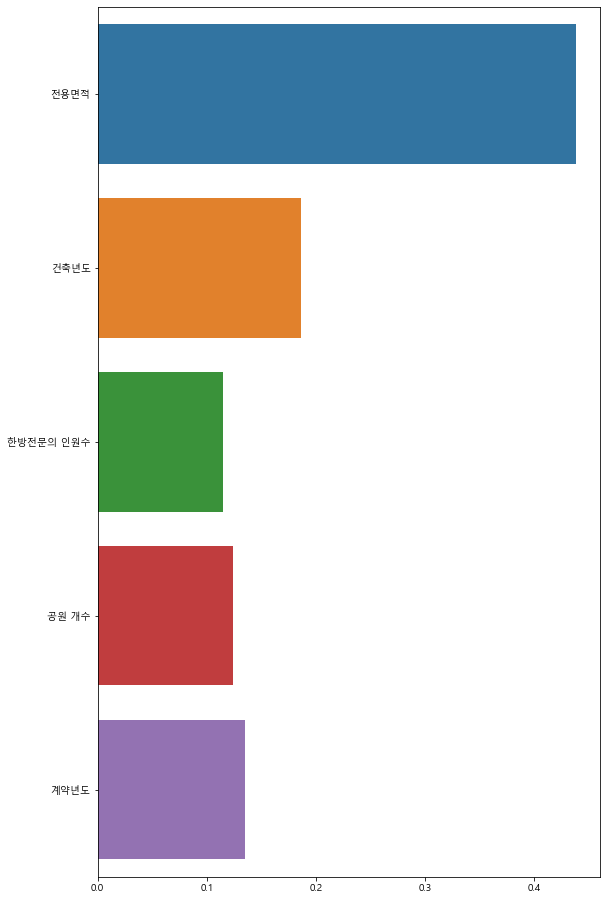

CPU times: user 1.23 s, sys: 4.06 ms, total: 1.24 s
Wall time: 1.24 s


In [29]:
%%time
X = df[['전용면적', '건축년도',
       '한방전문의 인원수',
       '공원 개수',
       '계약년도']]

y = df['실거래가']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Model_dtr = DecisionTreeRegressor(random_state = 0)
Model_dtr.fit(X_train, y_train)

y_hat = Model_dtr.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
print(np.sqrt(mse))

plt.figure(figsize = (9, 16))
sns.barplot(Model_dtr.feature_importances_,
            X.columns)
plt.show()

결과 :<br>
**Model8-3**의 성능이 가장 좋았음<br>
['전용면적', '건축년도', '법정동별인구수', '한방전문의 인원수', '공원 개수', '한강 근접 여부', '계약년도']
standardization
train_test_split()에서 test_size = 0.1
squrt(MSE)=8641

(random_state를 0 ~ 9까지 해서 나온 MSE들의 평균 = 8947)
